# Blade Damage Progress Grid, given the weather

In [6]:
### load the libraries

import numpy as np
import pandas as pd
import joblib
import os

In [2]:
### Load the trained model & Combine and prepare inputs

from tensorflow.keras.models import load_model

mdl_tag='model_reg_lstm_PA_MH_LV_09032021_sqlen.h5'  #this is "standard" v5 regularization
model=load_model(mdl_tag)
non_damage_scaler   = joblib.load('non_damage_scaler_09032021_sqlen.save')
damage_scaler       = joblib.load('damage_scaler_09032021_sqlen.save')

def prepare_input(df0, da_start, non_damage_scaler, damage_scaler):
    
    # constrained within function..might not be necessary if inputs already filtered to only include relevant features
    features0=['Total_prec','ws','TKE','da_start','sqlen']
    
    t_res='M'
    
    #------------------------func
    df=df0.copy()
    
    try:
        df.drop_duplicates(subset=['time'],inplace=True)
        #convert time to datetime
        df.time=pd.to_datetime(df.time)
        #set time as index
        df.set_index('time',inplace=True)
    
    except Exception:
        pass
    
    #5mar2021jtl-add sequence length feature
    df['sqlen']=len(df)
    
    # if damage at start is known and given...
    if da_start:
        df['da_start']=da_start*np.ones(len(df))
    # if no damage known or given, set to 0
    else:
        df['da_start']=0*np.ones(len(df))
    
    #downselect features
    df1=df.loc[:,features0].copy()
    
    # final filter
    df1.dropna(axis=0,how='any',inplace=True)    
    
    
    #---------apply scaler defined on training data
    
    df2=df1.copy()
    # df2[:]=X_scaler.transform(df2.values)
    
    features1=[x for x in features0 if 'da' not in x]
    
    df2.loc[:,features1]=   non_damage_scaler.transform(df2.loc[:,features1].values)
    df2.loc[:,'da_start']=        damage_scaler.transform(df2['da_start'].values.reshape(-1,1))
    
    
    #--------- try combine resampled stats
    features1=[x for x in df2.columns if (('da' not in x) and ('sqlen' not in x))]
    df2a=df2.copy().loc[:,features1].resample(t_res).max() 
    cols1=[x+'_max' for x in df2a.columns ]
    df2a.columns=cols1
    
    df2b=df2.copy().loc[:,features1].resample(t_res).mean()     
    cols2=[x+'_mean' for x in df2b.columns ]
    df2b.columns=cols2
    
    df2c=df2.copy().loc[:,['da_start','sqlen']].resample(t_res).median() #NB this will delete wf column as it is strings.
    
    #concat
    df2=pd.concat([df2a,df2b,df2c],axis=1)
        
    # final filter (again)
    df2.dropna(axis=0,how='any',inplace=True)
    
    #---------transform into lstm input
    
    X=df2.values
    X=X[np.newaxis,:,:]

    return X



## Note that the 'raw' weather input from is processed sequentially via:
1. DMI_Concat_Correlation_Plots.ipynb
2. DMI_WeightedSumPrecipitation_DataFrames.ipynb

### then used here ( read from Processed_DMI folder)

In [3]:
### Read processed weather input and make predictions

from pathlib import Path

nb_path = Path(os.getcwd())
folder_path = os.path.dirname(nb_path)

# Time interval to estimate/forecast blade damage progress
interval_start = '2015-05'
interval_end = '2017-05'

# Damage input
# if damage at input sequence start is known, define here.  otherwise, code assumes = 0
da_start = np.ones(shape=(7))*0

predicted_damage_scaled = []
for site in range(1,8):
    ### non-Anonymized weather data (files.dtu.dk)
    WF_weather = pd.read_csv(folder_path+'/Processed_DMI/WF'+str(site)+'_precip_WS_WD.csv',
                             index_col=0,
                             parse_dates=True)
    WF_weather_interval = WF_weather[interval_start:interval_end]
    WF_weather_yearly = WF_weather_interval['2019-05':'2020-05']

    # Transform input for ML    
    X=prepare_input(WF_weather_interval,da_start[site-1],non_damage_scaler,damage_scaler)
    
    # Make predictions
    predicted_damage_scaled.append(model.predict(X)[0])
    
predicted_damage = damage_scaler.inverse_transform(predicted_damage_scaled).reshape(len(predicted_damage_scaled),)
over_years = WF_weather_interval.index.year.max()-WF_weather_interval.index.year.min()

print('encoded damage progress over '+str(over_years)+'-year period: \n', predicted_damage)

encoded damage progress over 2-year period: 
 [ 81.90446519 519.84735037  46.28910531 142.29581039 563.23988564
 108.97802433 422.98793332]


### The sites available so far:
- WF1 Brorstrup, Denmark
- WF2 Løgtved Vindkraft, Denmark
- WF3 Østerild Test Centre, Denmark
- WF4 Tweenbridge Wind Farm, England
- WF5 Barrow Wind Farm, England
- WF6 Märkische Heide, Germany
- WF7 Princess Amalia, The Netherlands

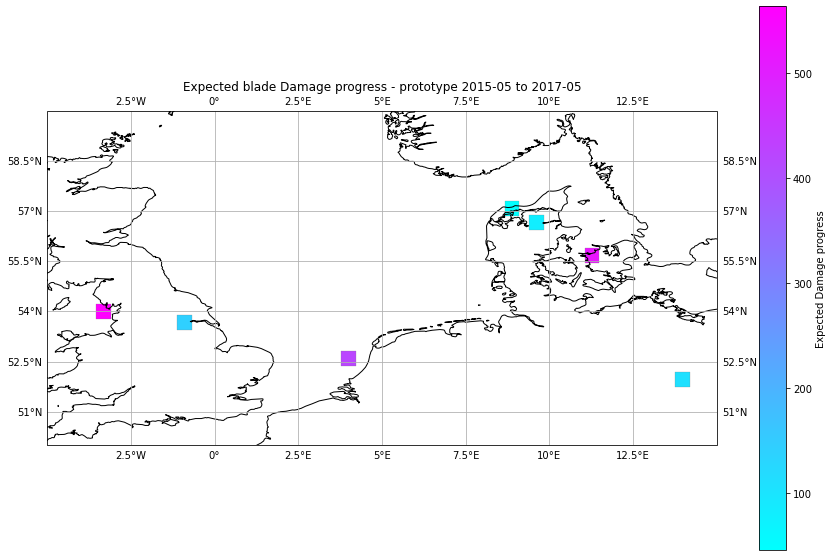

In [4]:
### Plot the grid on the map

# Currently only WF1 -- WF7 available

lat = [56.661, 55.6765, 57.0677, 53.6666, 54.0000, 51.9688, 52.5900]
lon = [9.6134, 11.2743, 8.8840, -0.8899,  -3.3200, 13.9799, 4,2200]

# rectangular patches for the grid map
def make_rect(clon, clat, dlon, dlat):
    lon_min = clon - dlon
    lat_min = clat - dlat
    lon_max = clon + dlon
    lat_max = clat + dlat
    ll = [lon_min,lat_min]
    ul = [lon_min,lat_max]
    ur = [lon_max,lat_max]
    lr = [lon_max,lat_min]
    return [ll, ul, ur, lr, ll]

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[15,10])
ax = plt.axes(projection=ccrs.PlateCarree(), extent=[-5, 15, 50, 60])

# plot rectangular patches around WF centres in the northern Europe map
dlon, dlat = .22, .22 # corresponds to 1-grid in DMI data

# adjust the colour pf the patches with new ones coming in
minv = min(predicted_damage)+min(da_start)
maxv = max(predicted_damage)+max(da_start)
cmap = plt.cm.cool
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Expected Damage progress')
for lon1, lat1, val1, init1 in zip(lon, lat, predicted_damage, da_start):
    pcorners = make_rect(lon1, lat1, dlon, dlat)
    poly = mpatches.Polygon(pcorners, ec='gray', fill=True, lw=0.25, \
           fc=cmap(norm(val1+init1)), transform=ccrs.PlateCarree())
    ax.add_patch(poly)   
    lon1 += 1
    ax.relim()
    ax.autoscale_view()
#     plt.pause(1)

ax.gridlines(draw_labels=True)
ax.coastlines()
plt.title('Expected blade Damage progress - prototype ' +interval_start+' to '+interval_end)

plt.show()


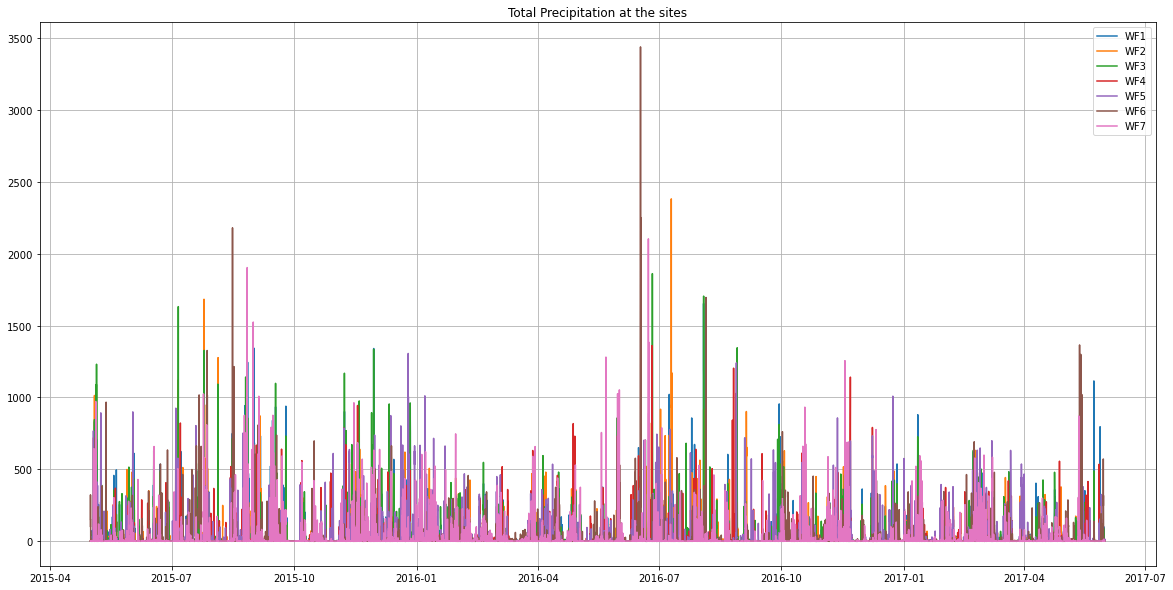

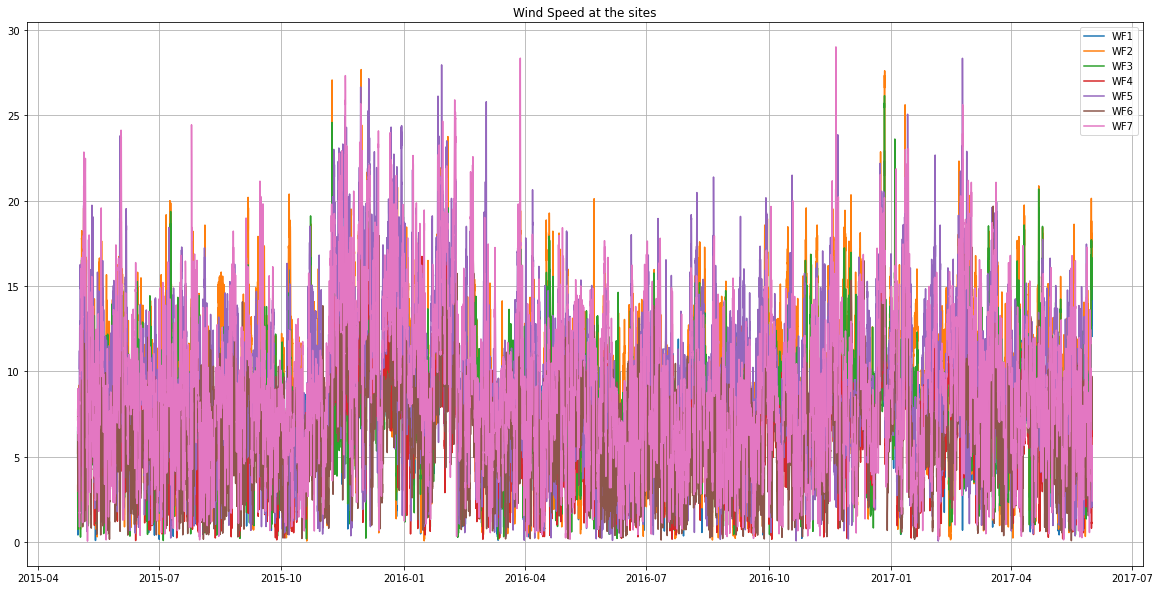

In [9]:
### Let's see how the weather looks like per year

plt.figure(figsize=(20,10))
# Total Precipitation
for site in range(1,8):
    ### non-Anonymized weather data (files.dtu.dk)
    WF_weather = pd.read_csv(folder_path+'/Processed_DMI/WF'+str(site)+'_precip_WS_WD.csv',
                             index_col=0,
                             parse_dates=True)
    WF_weather_interval = WF_weather[interval_start:interval_end]
    ax = plt.plot(WF_weather_interval.index, 
                  WF_weather_interval.Total_prec,
                  label = 'WF'+str(site))

plt.title('Total Precipitation at the sites')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,10))

# Wind Speed
for site in range(1,8):
    ### non-Anonymized weather data (files.dtu.dk)
    WF_weather = pd.read_csv(folder_path+'/Processed_DMI/WF'+str(site)+'_precip_WS_WD.csv',
                             index_col=0,
                             parse_dates=True)
    WF_weather_interval = WF_weather[interval_start:interval_end]
    ax = plt.plot(WF_weather_interval.index, 
                  WF_weather_interval.ws,
                  label = 'WF'+str(site))

plt.title('Wind Speed at the sites')
plt.grid()
plt.legend()
plt.show()

# make figure
fig = go.Figure()

# TKE
for site in range(1,8):
    ### non-Anonymized weather data (files.dtu.dk)
    WF_weather = pd.read_csv(folder_path+'/Processed_DMI/WF'+str(site)+'_precip_WS_WD.csv',
                             index_col=0,
                             parse_dates=True)
    WF_weather_interval = WF_weather[interval_start:interval_end]
    fig.add_trace(go.Scatter(x = WF_weather_interval.index, 
                             y = WF_weather_interval.TKE,
                             name = 'WF'+str(site)))
    fig.update_layout(title_text = 'TKE at the sites')

fig.show()


## De-code the predicted damage to the likehood of the expected severity increase
To do that, we retrace the steps from encoding where the severity increase was weighted twice.

- Max. severity increase = 1 --> 5 x 2 = 8
- Max. Damage increase = 1 --> 4 + 1 --> 5 x 2 = 3 + 8 = 11
- Avg. inspections per turbine per year = 300 (observed in PA for 2018, 2019, 2020)
- No increase in severity levels (0-level) are much likelier to see in shorter time intervals, then it reduces gradually
- Assuming probability of 1-level severity increase is higher (1.5times) than 2-level severity increase (observed trend in inspections)

Then the number of inspections (count) per severity increase (probabilities x number of inspections) should satisfy:

1. count(level-1) + 2 x count(level-2) + 3 x count(level-3) = predicted_damage x 8/11
2. count(level-0) + count(level-1) + count(level-2) + count(level-3) = Avg. inspections
3. count(level-1) = 1.5 x count(level-2)

likelihood of the severity increase over 2-year period: 
 [[0.5  0.5  0.   0.  ]
 [0.5  0.33 0.17 0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.31 0.19 0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.37 0.13 0.  ]]


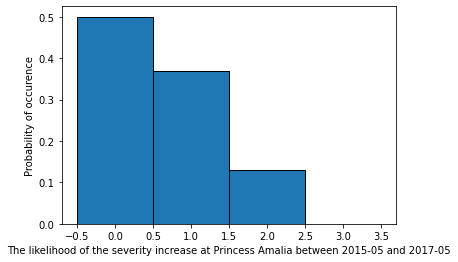

In [6]:
### Probabilities for severity increase P_0, P_1, P_2, P_3 based on the predicted damage progress (encoded)

def probabilities(predicted_damage, over_years):

    probabilities = np.zeros(shape=(len(predicted_damage), 4))
    max_delta_severity = predicted_damage*8/11
    avg_inspections = 300*over_years # (yearly) average inspections per turbine in PA for 2018, 2019, 2020

    # P_0 --> no increase in severity
    probabilities[:,0] = 0.7-(over_years*0.1) # strong trend seen in the observations for yearly inspections

    for i in range(len(predicted_damage)):
        A = np.array([[1, 2, 3],
                      [1, 1, 1],
                      [1, -1.5, 0]],
                      dtype='float')
        B = np.array([[max_delta_severity[i]],
                     [avg_inspections-avg_inspections*probabilities[i,0]],
                     [0]], dtype='float')
        counts = np.linalg.solve(A,B)
        if counts[-1] < 0:
            counts[-2] = counts[-2]+counts[-1]
            counts[-1] = 0
        if counts[-2] < 0:
            counts[-3] = counts[-3]+counts[-2]
            counts[-2] = 0
        probabilities[i,1:] = counts[:,0]/avg_inspections    
    probabilities = np.round(abs(probabilities),2)
    return probabilities

delta_severity = probabilities(predicted_damage, over_years)

print('likelihood of the severity increase over '+str(over_years)+'-year period: \n', delta_severity)

bins = np.arange(-0.5,4.5,1)
plt.bar(bins[:-1],delta_severity[-1],width=1, align="edge", ec="k" )
plt.xlabel('The likelihood of the severity increase at Princess Amalia between '+interval_start+' and '+interval_end)
plt.ylabel('Probability of occurence')
plt.show()

In [7]:
### Read Lightning Data

df_lyn = pd.read_csv(folder_path+'/Processed_DMI/DK_lyn_2010-2018.csv',
                     index_col=0,
                     parse_dates=True)
df_lyn_interval = df_lyn.loc[interval_start:interval_end]
df_lyn_interval

<ipython-input-7-12e6a2225bbd>:6: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



version      lat      lon  peak_current  \
2015-05-01 02:00:40.337373700        0  55.4283  11.5529            -6   
2015-05-01 02:13:49.088114752        0  55.5078  11.6028           -12   
2015-05-01 02:13:49.258187910        0  55.5085  11.5754            -4   
2015-05-01 02:16:16.181284096        0  55.4908  11.6209           -17   
2015-05-01 02:16:16.191992116        0  55.4951  11.6142            -9   
...                                ...      ...      ...           ...   
2017-05-31 14:38:21.440414195        0  58.0716  12.9151           -46   
2017-05-31 14:38:21.502968470        0  58.0720  12.9163           -22   
2017-05-31 14:48:04.743752411        0  58.1155  12.8833           -41   
2017-05-31 14:48:04.804401320        0  58.0707  13.3243           -63   
2017-05-31 14:48:04.840827741        0  58.0554  13.3200           -14   

                               multiplicity  number_sensors  DoF  ell_angle  \
2015-05-01 02:00:40.337373700             0               5    6       48.2   
2015-05-01 02:13:49.088114752             0               6    8       26.9   
2015-05-01 02:13:49.258187910             0               2    1      105.3   
2015-05-01 02:16:16.181284096             0               5    6       37.7   
2015-05-01 02:16:16.191992116             0               6    8       27.1   
...                                     ...             ...  ...        ...   
2017-05-31 14:38:21.440414195             0               6    9       27.3   
2017-05-31 14:38:21.502968470             0               6    9       27.3   
2017-05-31 14:48:04.743752411             0               3    3       27.1   
2017-05-31 14:48:04.804401320             0               6    9       30.6   
2017-05-31 14:48:04.840827741             0               4    5       32.5   

                               semi-major_axis  minor_axis  chi_square  \
2015-05-01 02:00:40.337373700              0.4         0.3         0.4   
2015-05-01 02:13:49.088114752              0.3         0.3         0.9   
2015-05-01 02:13:49.258187910              2.8         0.4         1.4   
2015-05-01 02:16:16.181284096              0.5         0.3         0.5   
2015-05-01 02:16:16.191992116              0.3         0.3         1.6   
...                                        ...         ...         ...   
2017-05-31 14:38:21.440414195              1.7         0.4         1.6   
2017-05-31 14:38:21.502968470              1.8         0.4         1.3   
2017-05-31 14:48:04.743752411              2.4         0.5         1.5   
2017-05-31 14:48:04.804401320              1.8         0.4         1.9   
2017-05-31 14:48:04.840827741              2.1         0.5         0.4   

                               rise_time  peak-to-zero_time  max_rate-of-rise  \
2015-05-01 02:00:40.337373700        2.2                3.2              -0.0   
2015-05-01 02:13:49.088114752        3.0               12.4              -0.0   
2015-05-01 02:13:49.258187910        1.4                5.6              -0.0   
2015-05-01 02:16:16.181284096        3.0               26.6              -0.0   
2015-05-01 02:16:16.191992116        4.6               14.0              -0.0   
...                                  ...                ...               ...   
2017-05-31 14:38:21.440414195        7.0               26.8              -0.0   
2017-05-31 14:38:21.502968470        6.0               21.8              -0.0   
2017-05-31 14:48:04.743752411        6.6               30.2              -0.0   
2017-05-31 14:48:04.804401320       12.8               30.2              -0.0   
2017-05-31 14:48:04.840827741        4.2               27.8              -0.0   

                               clud_indicator  angle_indicator  \
2015-05-01 02:00:40.337373700               1                1   
2015-05-01 02:13:49.088114752               0                1   
2015-05-01 02:13:49.258187910               1                1   
2015-05-01 02:16:16.181284096               0                1   
2

In [9]:
## Group lightning data per grid

df_lyn_interval['lat_bin'] = pd.cut(df_lyn_interval['lat'], 
                                    bins=np.arange(min(df_lyn_interval.lat),max(df_lyn_interval.lat),.22))
df_lyn_interval['lon_bin'] = pd.cut(df_lyn_interval['lon'], 
                                    bins=np.arange(min(df_lyn_interval.lon),max(df_lyn_interval.lon),.22))
df_lyn_interval_per_grid = df_lyn_interval[df_lyn_interval['peak_current']<0].groupby(['lat_bin', 'lon_bin']).sum()
df_lyn_interval_per_grid.reset_index(inplace=True)

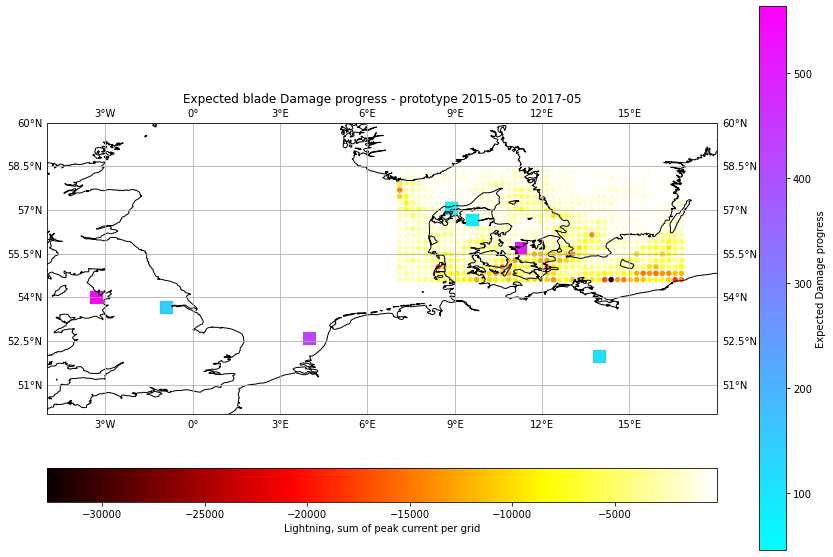

In [10]:
### Plot the grid on the map

# Currently only WF1 -- WF7 available

lat = [56.661, 55.6765, 57.0677, 53.6666, 54.0000, 51.9688, 52.5900]
lon = [9.6134, 11.2743, 8.8840, -0.8899,  -3.3200, 13.9799, 4,2200]

# rectangular patches for the grid map
def make_rect(clon, clat, dlon, dlat):
    lon_min = clon - dlon
    lat_min = clat - dlat
    lon_max = clon + dlon
    lat_max = clat + dlat
    ll = [lon_min,lat_min]
    ul = [lon_min,lat_max]
    ur = [lon_max,lat_max]
    lr = [lon_max,lat_min]
    return [ll, ul, ur, lr, ll]

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[15,10])
ax = plt.axes(projection=ccrs.PlateCarree(), extent=[-5, 18, 50, 60])

# plot rectangular patches around WF centres in the northern Europe map
dlon, dlat = .22, .22 # corresponds to 1-grid in DMI data

# adjust the colour pf the patches with new ones coming in
minv = min(predicted_damage)+min(da_start)
maxv = max(predicted_damage)+max(da_start)
cmap = plt.cm.cool
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Expected Damage progress')
for lon1, lat1, val1, init1 in zip(lon, lat, predicted_damage, da_start):
    pcorners = make_rect(lon1, lat1, dlon, dlat)
    poly = mpatches.Polygon(pcorners, ec='gray', fill=True, lw=0.25, \
           fc=cmap(norm(val1+init1)), transform=ccrs.PlateCarree())
    ax.add_patch(poly)   
    lon1 += 1
    ax.relim()
    ax.autoscale_view()
    
plt.scatter(pd.IntervalIndex(df_lyn_interval_per_grid.lon_bin).mid,
           pd.IntervalIndex(df_lyn_interval_per_grid.lat_bin).mid,
           c=df_lyn_interval_per_grid['peak_current'],
           cmap='hot',
           s=20)
plt.colorbar(label='Lightning, sum of peak current per grid', 
             orientation="horizontal", pad=0.1)

ax.gridlines(draw_labels=True)
ax.coastlines()
plt.title('Expected blade Damage progress - prototype ' +interval_start+' to '+interval_end)

plt.show()
